<a href="https://colab.research.google.com/github/elenakelly/Tweet-Emotion-Recognition/blob/main/TweetEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [95]:
!pip install nlp

In [96]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [97]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [98]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [99]:
train = dataset['train']
validation = dataset['validation']
test = dataset['test']

In [100]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [101]:
tweets, labels = get_tweet(train)

In [102]:
tweets[10], labels[10]

('i feel like i have to make the suffering i m seeing mean something',
 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [103]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [104]:
tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [105]:
print(tweets[10])
tokenizer.texts_to_sequences([tweets[10]])

i feel like i have to make the suffering i m seeing mean something


[[2, 3, 14, 2, 21, 5, 80, 6, 733, 2, 93, 544, 304, 84]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

<function matplotlib.pyplot.show>

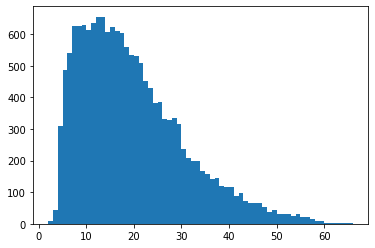

In [106]:
lenghts = [len(t.split(' ')) for t in tweets]
plt.hist(lenghts, bins = len(set(lenghts)))
plt.show

In [107]:
maxlen = 500
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [108]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post')
  return padded


In [109]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [110]:
padded_train_seq[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [111]:
classes = set(labels)
print(classes)

{'sadness', 'love', 'joy', 'anger', 'fear', 'surprise'}


<function matplotlib.pyplot.show>

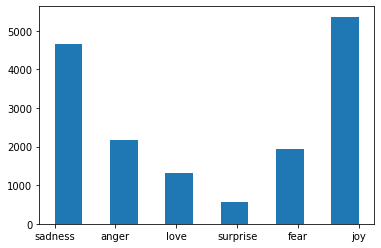

In [112]:
plt.hist(labels, bins=11)
plt.show

In [113]:
classes_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in classes_to_index.items())

In [114]:
classes_to_index

{'anger': 3, 'fear': 4, 'joy': 2, 'love': 1, 'sadness': 0, 'surprise': 5}

In [115]:
index_to_class

{0: 'sadness', 1: 'love', 2: 'joy', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [116]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [117]:
train_labels = names_to_ids(labels)
print(train_labels[10])

0


## Creating the Model

1. Creating the model
2. Compiling the model

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Bidirectional, LSTM


In [119]:
model = Sequential([Embedding(10000, 16, input_length= maxlen),
                    Bidirectional(LSTM(20, return_sequences = True)),
                    Bidirectional(LSTM(20)),
                    Dense(6, activation='softmax')
                    ])



model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 500, 16)           160000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 500, 40)          5920      
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 40)               9760      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________
None


## Training the Model

1. Preparing a validation set
2. Training the model

In [120]:
val_tweets, val_labels = get_tweet(validation)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [121]:
val_tweets[10], val_labels[10]

('i feel bitchy but not defeated yet', 3)

In [122]:
from keras.callbacks import EarlyStopping

In [123]:
h = model.fit(padded_train_seq, train_labels,
              validation_data=(val_seq, val_labels), 
              epochs=20, 
              callbacks=[EarlyStopping(monitor= 'val_accuracy', patience=2)]
              )

Epoch 1/20


ValueError: ignored

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

In [ ]:
show_history(h)

In [124]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels =names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

In [126]:
i = random.randint(0, len(test_labels) - 1)
print("Sentence: ", test_tweets[i])
print("Emotion: ", index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('unit8')]

print("Predicted Emotion: ", pred_class)

Sentence:  i rarely feel happily joyful and dont walk about smiling much
Emotion:  joy


In [ ]:
preds = model.predict_classes(test_seq)

In [ ]:
show_confusion_matrix(test_labels, preds, list(classes))